## Learning to rank with LambdaMART

In this notebook we apply the LambdaMART, a pairwise learning to rank method, to a text search data set. We use the XGBoost implementation of LambdaMART. 

In [1]:
import numpy as np
import pickle
import xgboost as xgb
import graphviz
import matplotlib
import math
#from sklearn.model_selection import train_test_split

import xgboost as xgb



## Data

The data I use is the ENTRP-SRCH dataset.

The data is a LETOR-formatted, of the form: "reference lable (ie ranking given by human), query id, query-url pairs (length 8 feature vectors)".  
 

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/entrp-srch/ENTRP-SRCH-v13.txt
/kaggle/input/entrp-srch/ENTRP-SRCH-v12.txt


In [3]:
#qid query
#1 asian
#2 biochemistry
#3 botany
#4 chaplaincy
#5 classics
#6 commercial
#7 dental
#8 Engineering
#9 English
#10 european studies
#11 genetics
#12 geology
#13 history
#14 italian
#15 microbiology
#16 philosophy
#17 religion
#18 sociology
#19 walton clun
#20 zoology

# train
# 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17

# test
# 11,12,13,14,15,16,17

# vali
# 18,19,20

In [4]:
#drop feature 8 (CTR) located in column 10
#!awk '!($10="")' ../input/entrp-srch/ENTRP-SRCH-v13.txt | sed 's/[ \t]*$//' > ENTRP-SRCH-v13-no-8.txt  # trim trailing whitespaces
#!head -1 ../input/entrp-srch/ENTRP-SRCH-v13.txt
#!head -1 ENTRP-SRCH-v13-no-8.txt

In [5]:

!cat ../input/entrp-srch/ENTRP-SRCH-v13.txt | grep -v -w "8:0.0" | awk '{$1=$10}1' | awk '{$10=""}1' | sed 's/[ \t]*$//' | cut -c 3- > ENTRP-SRCH-v13-CTR.txt

In [6]:
# ensure train, test and vali data are empty to start with
!cp -p /dev/null train.txt 2>/dev/null
!cp -p /dev/null test.txt  2>/dev/null
!cp -p /dev/null vali.txt  2>/dev/null

In [7]:
judgements = "CTR"  # posssible values are HUMAN or CTR
if judgements == "CTR":
  print("judgements is CTR")
  !cat ../input/entrp-srch/ENTRP-SRCH-v13.txt | grep -v -w "8:0.0" | awk '{$1=$10}1' | awk '{$10=""}1' | sed 's/[ \t]*$//' | cut -c 3- > ENTRP-SRCH-v13-CTR.txt
  !for SITE in 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17; do grep "qid:${SITE} " ENTRP-SRCH-v13-CTR.txt >> train.txt; done
  !for SITE in 11 12 13 14 15 16 17; do grep "qid:${SITE} " ENTRP-SRCH-v13-CTR.txt  >> test.txt; done
  !for SITE in 18 19 20; do grep "qid:${SITE} " ENTRP-SRCH-v13-CTR.txt  >> vali.txt; done
else:
  print("judgements is HUMAN")
  !for SITE in 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17; do grep "qid:${SITE} " ../input/entrp-srch/ENTRP-SRCH-v13.txt >> train.txt; done
  !for SITE in 11 12 13 14 15 16 17; do grep "qid:${SITE} " ../input/entrp-srch/ENTRP-SRCH-v13.txt >> test.txt; done
  !for SITE in 18 19 20; do grep "qid:${SITE} " ../input/entrp-srch/ENTRP-SRCH-v13.txt >> vali.txt; done
    

judgements is CTR


In [8]:
#!for SITE in 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17; do grep "qid:${SITE} " ../input/entrp-srch/ENTRP-SRCH-v13.txt >> train.txt; done
#!for SITE in 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17; do grep "qid:${SITE} " ENTRP-SRCH-v13-CTR.txt >> train.txt; done
!wc -l train.txt


317 train.txt


In [9]:
#!for SITE in 11 12 13 14 15 16 17; do grep "qid:${SITE} " ../input/entrp-srch/ENTRP-SRCH-v13.txt >> test.txt; done
#!for SITE in 11 12 13 14 15 16 17; do grep "qid:${SITE} " ENTRP-SRCH-v13-CTR.txt  >> test.txt; done
!wc -l test.txt

141 test.txt


In [10]:
#!for SITE in 18 19 20; do grep "qid:${SITE} " ../input/entrp-srch/ENTRP-SRCH-v13.txt >> vali.txt; done
#!for SITE in 18 19 20; do grep "qid:${SITE} " ENTRP-SRCH-v13-CTR.txt  >> vali.txt; done
!wc -l vali.txt

58 vali.txt


In [11]:
## allocating train, test and validate datafiles with the dataset
#import random 


# 75%,12.5%,12.5% split for train, test, vali
#fin = open('../input/entrp-srch/ENTRP-SRCH-v13.txt', 'rb') 
#fin = open('ENTRP-SRCH-v13-no-8.txt', 'rb') 
#f75out = open("train.txt", 'wb') 
#f125aout = open("test.txt", 'wb')
#f125bout = open("vali.txt", 'wb')

#for line in fin: 
#  r = random.random() 
#  if (0.0 <=  r <= 0.75): 
#    f75out.write(line) 
#  elif (0.75 < r <= 0.995): 
#    f125aout.write(line) 
#  else:
#    f125bout.write(line)
#fin.close() 
#f75out.close() 
#f125aout.close() 
#f125bout.close() 

In [12]:
!head -1 train.txt; wc -l train.txt
!head -1 test.txt; wc -l test.txt
!head -1 vali.txt; wc -l vali.txt

0.19 qid:1 1:8.505065 2:0.17140295 3:0.0 4:0.0 5:34.0 6:6.0 7:1.080049
317 train.txt
0.16 qid:11 1:5.4893785 2:0.25886798 3:0.0 4:0.0 5:146.0 6:6.0 7:1.0578148
141 test.txt
0.16 qid:18 1:5.780672 2:0.25886798 3:0.0 4:0.0 5:132.0 6:6.0 7:2.7021856
58 vali.txt


In [13]:
#!rm -f *_*
## remove qid from the files.
!sed 's/[[:space:]][a-z]*:[0-9]*//g' train.txt > train_dat.txt
!sed 's/[[:space:]][a-z]*:[0-9]*//g' vali.txt > vali_dat.txt
!sed 's/[[:space:]][a-z]*:[0-9]*//g' test.txt > test_dat.txt
!echo "removed qids"
# extract the qids to their own files
!grep -oh "qid:[0-9]*" train.txt > qids.txt
!grep -oh "qid:[0-9]*" test.txt > test_qids.txt
!grep -oh "qid:[0-9]*" vali.txt > vali_qids.txt
!echo "extracted qids"
## make freq table from qids
!uniq -c qids.txt > train_dat1.txt.group
!uniq -c test_qids.txt > test_dat1.txt.group
!uniq -c vali_qids.txt > vali_dat1.txt.group
!echo "made frequency tables"
## extract first entry from frequency table
!awk -F " " '{print $1}' train_dat1.txt.group > train_dat.txt.group
!awk -F " " '{print $1}' test_dat1.txt.group > test_dat.txt.group
!awk -F " " '{print $1}' vali_dat1.txt.group > vali_dat.txt.group
!wc -l *

removed qids
extracted qids
made frequency tables
   375 ENTRP-SRCH-v13-CTR.txt
  1620 __notebook__.ipynb
   317 qids.txt
   141 test.txt
   141 test_dat.txt
     7 test_dat.txt.group
     7 test_dat1.txt.group
   141 test_qids.txt
   317 train.txt
   317 train_dat.txt
    17 train_dat.txt.group
    17 train_dat1.txt.group
    58 vali.txt
    58 vali_dat.txt
     3 vali_dat.txt.group
     3 vali_dat1.txt.group
    58 vali_qids.txt
  3597 total


In [14]:
#!tail -10 qids.txt
!uniq -c qids.txt


     20 qid:1
     13 qid:2
     19 qid:3
     20 qid:4
     20 qid:5
     11 qid:6
     20 qid:7
     19 qid:8
     18 qid:9
     16 qid:10
     20 qid:11
     20 qid:12
     20 qid:13
     21 qid:14
     20 qid:15
     20 qid:16
     20 qid:17


In [15]:


import xgboost as xgb
#dtrain = xgb.DMatrix(f75out, label=y_train)
#dtest = xgb.DMatrix(f125aout, label=y_test)


In [16]:
#training_data = xgb.DMatrix('train.txt')
#testing_data = xgb.DMatrix('test.txt')

#training_data = xgb.DMatrix('../input/tcdletorformat/train_dat.txt')
#exim = xgb.DMatrix('../input/entrp-srch/ENTRP-SRCH-v13.txt')
#testing_data = xgb.DMatrix('../input/tcdletorformat/test_dat.txt')




In [17]:
#exim.print.xgb.DMatrix

In [18]:
#train, test = train_test_split(exim, test_size=0.2, random_state=0)
#train.to_txt('train.txt', index=False)
#test.to_txt('test.txt', index=False)

In [19]:
import pandas as pd
#testing_data_file = ''
#testing_data_file = '../input/tcdletorformat/test_dat.txt'
#col_names = ["Relevance", "BM25", "Recency", "isAbout", "isContact", "Popularity", "URLLength"]
#testing_data_set = pd.read_csv(testing_data_file, names=col_names, sep = "\s+|\t+|\s+\t+|\t+\s+") #, sep =' ') #, header = None)
training_data_set = pd.read_csv('train_dat.txt', sep = ' ', header = None) #"\s+|\t+|\s+\t+|\t+\s+") #, sep =' ') #, header = None)
testing_data_set = pd.read_csv('test_dat.txt', sep = ' ', header = None) #"\s+|\t+|\s+\t+|\t+\s+") #, sep =' ') #, header = None)



In [20]:
#Drop the columns where all elements are NaN:
#training_data_set = training_data_set.dropna(axis=1, how='all')
#training_data_set.drop(training_data_set.columns[i], axis=1)

In [21]:
training_data = xgb.DMatrix('train_dat.txt') #../LearningToRank/MSLR-WEB10K/Fold1/train_dat.txt')
testing_data = xgb.DMatrix('test_dat.txt') #../LearningToRank/MSLR-WEB10K/Fold1/test_dat.txt')"


[08:26:33] 317x8 matrix with 2219 entries loaded from train_dat.txt
[08:26:33] 17 groups are loaded from train_dat.txt.group
[08:26:33] 141x8 matrix with 987 entries loaded from test_dat.txt
[08:26:33] 7 groups are loaded from test_dat.txt.group


In [22]:
testing_data_set.head(5)

,0,1,2,3,4,5,6,7
0,0.16,1:5.4893785,2:0.25886798,3:0.0,4:0.0,5:146.0,6:6.0,7:1.0578148
1,0.12,1:5.638312,2:0.20192482,3:0.0,4:0.0,5:24.0,6:7.0,7:0.37818468
2,0.12,1:4.848951,2:0.34234384,3:0.0,4:0.0,5:22.0,6:7.0,7:0.37818468
3,0.15,1:4.848951,2:0.1889067,3:0.0,4:0.0,5:22.0,6:7.0,7:0.3781847
4,0.16,1:7.0278425,2:0.33792195,3:0.0,4:0.0,5:14.0,6:8.0,7:0.37818468


In [23]:
# Drop Human Judgements and use CTR instead (drop column 1, move column 8 to column 1)


## Building a Model

We now set the model parameters:

'max_depth' = number of layers in the tree
'eta' = step shrinkage size, used to prevent overfitting
'silent' = if 1, doesn't print updates. 
'objective' = which method is used/which objective function is minimised. 'rank:pairwise' implements LambdaMART.
'num_round' = number of boosting rounds. 

* rank:pairwise: Use LambdaMART to perform pairwise ranking where the pairwise loss is minimized 
* rank:ndcg: Use LambdaMART to perform list-wise ranking where Normalized Discounted Cumulative Gain (NDCG) is maximized

In [24]:
param = {'max_depth':10, 'eta':0.3, 'objective':'rank:pairwise', 'num_round':15}
#param = {'max_depth':5, 'eta':0.3, 'objective':'rank:ndcg', 'num_round':15}

#param2 = {'max_depth':3, 'eta':0.3, 'objective':'rank:pairwise', 'num_round':15}

In [25]:
model = xgb.train(param, training_data)
#model2 = xgb.train(param2, training_data)


[08:26:33] WARNING: /workspace/src/learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




## Visualising the model

The model takes the form of a decision tree, where splits at nodes are conditional on the inputted features in the feature vector for each query.  

In [26]:
%matplotlib inline

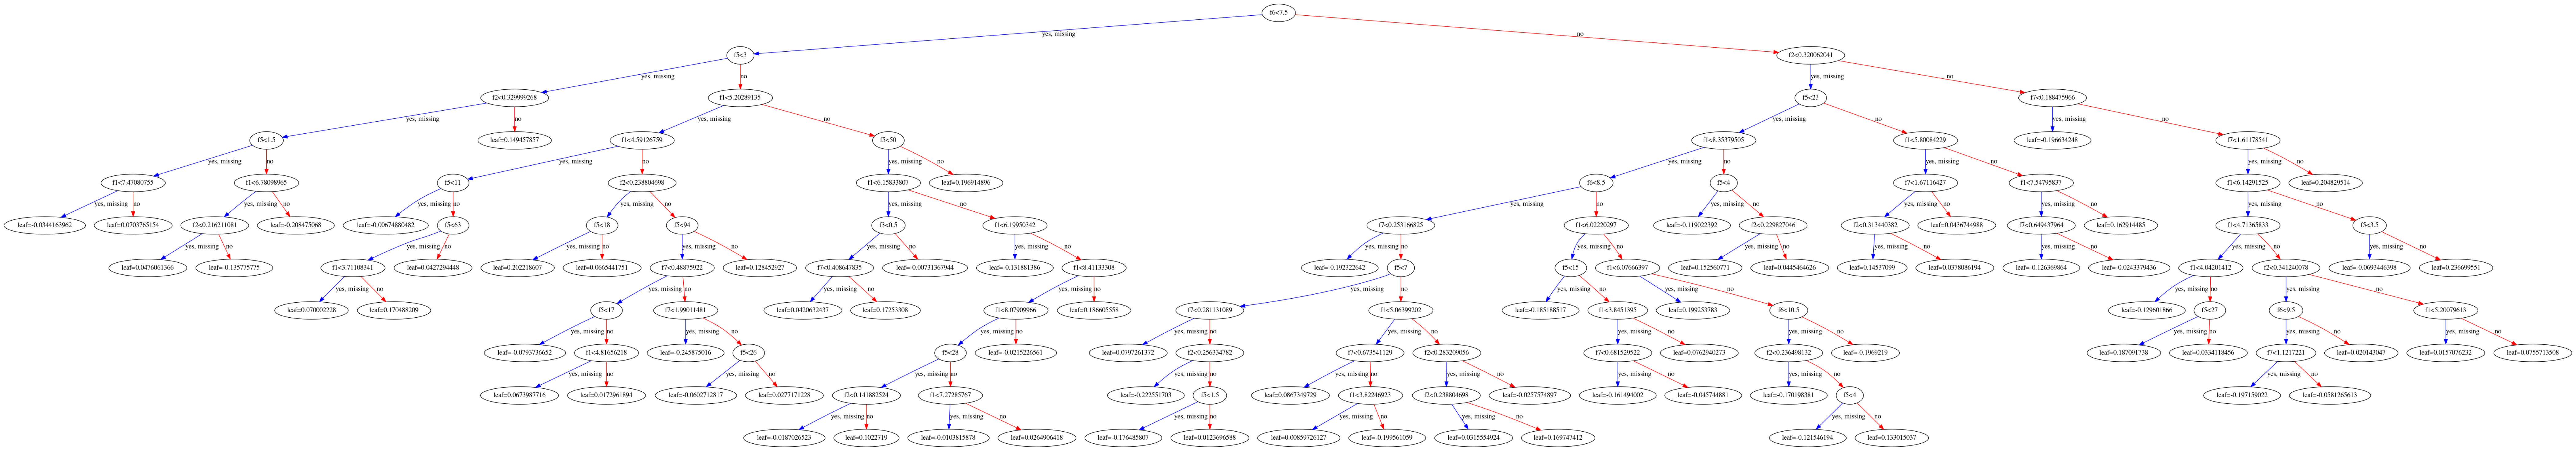

In [27]:
xgb.plot_tree(model, num_trees=3)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)

In [28]:
#xgb.plot_tree(model2, num_trees=3)
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(150, 100)

It is possible to look a the importance of each of the 6 features within the model. In the feature plot below we see that the most 'important' feature in determining the output of the model for a given input is feature 1 (BM25)


* feature 1: BM25  (like tf-idf, but with a probablistic twist)
* feature 2: documentRecency (last modification date)
* feature 3: isContact  (url contains the word 'contact')
* feature 4: isAbout    (url contains keyword 'about')
* feature 5: rawHits    (a measure of document popularity)
* feature 6: urlLength  (number of terms in url path hierarchy)
* feature 7: linkRank  (Like Google's PageRank, but for ES)
* feature 8: clickThru  (CTR rate taken over a six-month period)



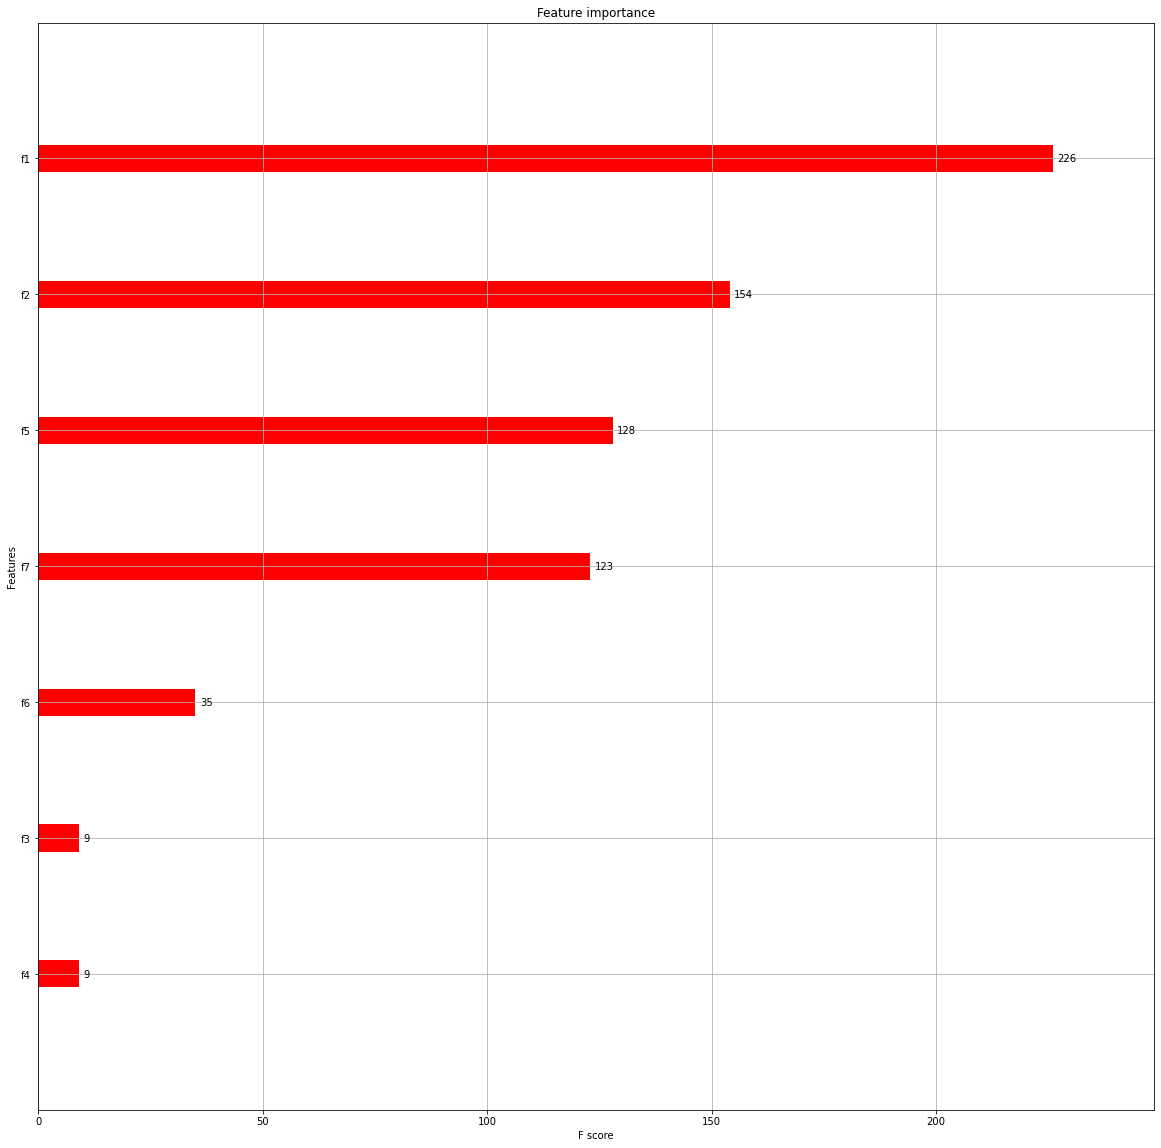

In [29]:
ax = xgb.plot_importance(model, color='red')
fig = ax.figure
fig.set_size_inches(20, 20)

In [30]:
from xgboost import plot_importance
from matplotlib import pyplot
# plot feature importance
#ax = xgb.plot_importance(model, color='blue')
#plot_importance(model)
#pyplot.show()
#fig = ax.figure
#fig.set_size_inches(40, 40)

In [31]:
#print(model.booster().feature_importances_)
#model.booster().get_score(importance_type='weight')
#from xgboost import XGBClassifier
#pyplot.bar(range(len(model.feature_importances_)), ax.feature_importances_)
#pyplot.show()

## Making predictions

'preds' contains predicted relelvance values for all of the queries in the testing data set. We want to compute the normalised discounted cumulative gain, or ndgc, of the results, in order to quantify the goodness of the model. This will allow us to compare models and tuning parameters. 

Predictions are made by passing a feature vector from the testing data set through the decision tree, ending at a leaf which gives a numerical value. The numerical value represents the relavance of that document for that query. 

In [32]:
preds = model.predict(testing_data)
#preds2 = model2.predict(testing_data)

In [33]:
#preds

#  Normal Distributed Cumulative Gain 
ndcg is a metric commonly used to rate the output of learning to rank models.
ndcg is a measure of the relative goodness of the output of the ranking algorithm, and takes value between 0 and 1, with a 1 denoting that the algorithm has optimally ordered the pages for a query, and a 0 denoting that the pages have been reverse ordered. 

In [34]:
""" this returns 0 if all of the ordered data is undesirable"""
def ndcg_p(ordered_data, p):
    """normalised discounted cumulative gain"""
    if sum(ordered_data)==0:
        return 0
    else:
        indexloop = range(0, p)
        DCG_p = 0
        for index in indexloop:
            current_ratio=(2**(ordered_data[index])-1)*(math.log((float(index)+2), 2)**(-1))
            DCG_p = DCG_p + current_ratio
        ordered_data.sort(reverse=True)  
        K = len(ordered_data)
        indexloop = range(0, K)
        iDCG_p = 0
        for index in indexloop:
            current_ratio=(2**(ordered_data[index])-1)*((math.log((index+2), 2))**(-1))
            iDCG_p = iDCG_p + current_ratio
        return(DCG_p/iDCG_p)

In [35]:
#!cat train_dat.txt.group

In [36]:
#!cat train_dat.txt.group | wc -l  # should be 20

In [37]:

f = open('vali_dat.txt.group', 'r')

x = f.readlines()
groups =[]
for line in x:
    groups.append(int(line))
f.close()

In [38]:
#testing_labels

In [39]:
testing_labels = testing_data.get_label()

In [40]:
#testing_labels

In [41]:
## compute ndgc for each query.
nquerys=range(0,len(groups))
lower=0
upper=0
ndcgs=[]
for i in nquerys:
        many=groups[i]
        upper = upper+many
        predicted = preds[lower:upper]
        labled = testing_labels[lower:upper]
        ordered = [x for _,x in sorted(zip(predicted,labled), reverse=True)]
        result = ndcg_p(ordered, many)
        ndcgs.append(result)
        lower=upper


In [42]:
ndcgs

[0.9994108232748342, 1.0, 0.9989139393250017]

In [43]:
# evaluate using the nDCG metric
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

# **nDCG Scores**

In [44]:
cutoffs = [1,3,5,10,20,100,200]
for x in cutoffs:
  print ("nDCG@"+ str(x) + ' = '" %s " % (ndcg_at_k(preds,x, method=1)))


nDCG@1 =  0.9863397894305374 
nDCG@3 =  0.805959766498764 
nDCG@5 =  0.8238933508510757 
nDCG@10 =  0.5500902934266912 
nDCG@20 =  0.30875576359476986 
nDCG@100 =  0.3036864366131009 
nDCG@200 =  0.5616736779399627 
